In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to GANs

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture. 

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN. 



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

In [ ]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)    

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

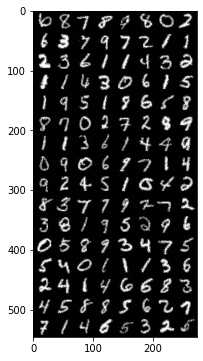

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm 
- ReLU

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU, 
    except the last block (which is only followed by tanh)
    '''
    if not last_layer:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
      model=nn.Sequential(nn.ConvTranspose2d(channels_in,channels_out,kernel_size=kernel,stride=stride,padding=padding),
                         nn.BatchNorm2d(channels_out),
                         nn.LeakyReLU(0.2,inplace=True))
      return model
    else:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
      model=nn.Sequential(nn.ConvTranspose2d(channels_in,channels_out,kernel_size=kernel,stride=stride,padding=padding),nn.Tanh())
      return model



class Generator(nn.Module):
    def __init__(self, nz, ngf , nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        
        self.model = nn.Sequential(get_upscaling_block(nz, ngf * 4, 4, 1, 0),
                                   get_upscaling_block(ngf * 4, ngf * 2, 4, 2, 1),
                                   get_upscaling_block(ngf * 2, ngf , 4, 2, 1),
                                   get_upscaling_block(ngf , nchannels, 4, 2, 1,last_layer=True))     
        ###################
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)
        

### 2.1.3. Sanity Tests

In [ ]:
nz = 1000
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

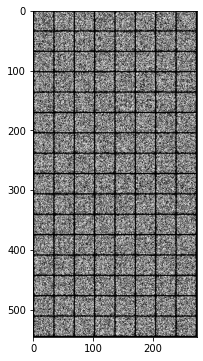

In [ ]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator. 

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]` 

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    
    if is_last:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),nn.Sigmoid())
    
    elif not use_batch_norm:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),    
                            nn.LeakyReLU(0.2, inplace=True))
    
    
    else:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        model=nn.Sequential(nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
                            nn.BatchNorm2d(channels_out),
                            nn.LeakyReLU(0.2, inplace=True))
    
    return model


class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        
        self.model = nn.Sequential(get_downscaling_block(nchannels,ndf,4,2,1),
                                   get_downscaling_block(ndf,ndf*2,4,2,1),
                                   get_downscaling_block(ndf*2,ndf*4,4,2,1),
                                   get_downscaling_block(ndf*4,1,4,2,0,is_last=True))
        
        #                 #
        ###################

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss 
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions. 
1. First, we need to continuously sample z from a Gaussian distribution. 
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s. 

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [ ]:
nz = 1000
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf, nchannels).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training! 
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve. 
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 1.6041468381881714; d_loss: 0.4987369775772095; avg_real_score: 0.6594831347465515; avg_fake_score: 0.38364726305007935: : 0it [00:00, ?it/s]

generated images


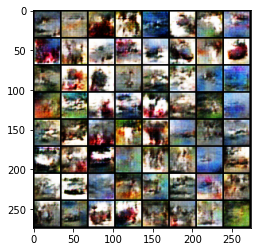

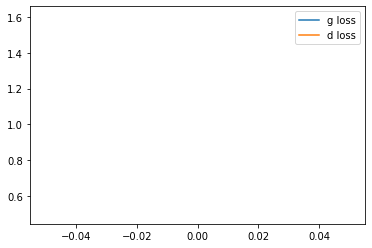

it: 200; g_loss: 1.7394170761108398; d_loss: 0.5129275918006897; avg_real_score: 0.6637346744537354; avg_fake_score: 0.398044228553772: : 200it [00:25,  7.93it/s]  

generated images


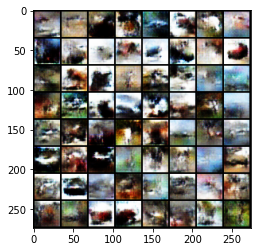

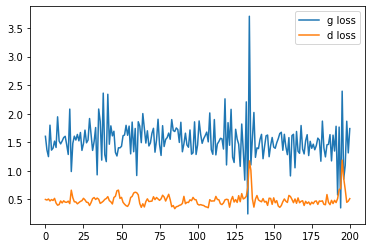

it: 390; g_loss: 1.741276741027832; d_loss: 0.309298038482666; avg_real_score: 0.7946672439575195; avg_fake_score: 0.3039783239364624: : 391it [00:49,  7.98it/s]
it: 391; g_loss: 1.9248216152191162; d_loss: 0.3854186236858368; avg_real_score: 0.7418752312660217; avg_fake_score: 0.3483390212059021: : 0it [00:00, ?it/s]

generated images


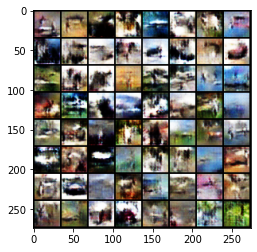

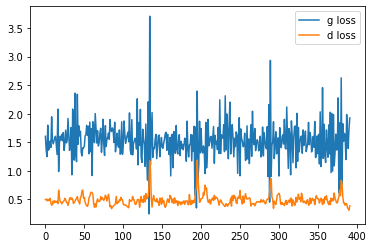

it: 591; g_loss: 1.7362515926361084; d_loss: 0.4587612748146057; avg_real_score: 0.7026252746582031; avg_fake_score: 0.38775303959846497: : 200it [00:25,  8.09it/s]

generated images


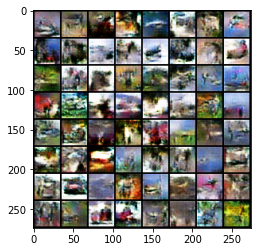

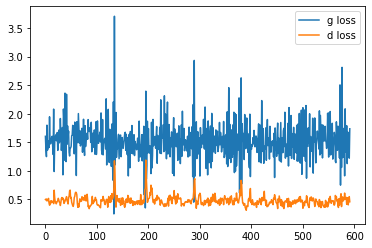

it: 781; g_loss: 2.0447566509246826; d_loss: 0.4695131182670593; avg_real_score: 0.7706173062324524; avg_fake_score: 0.4610963761806488: : 391it [00:49,  7.85it/s]
it: 782; g_loss: 1.1259052753448486; d_loss: 0.5188932418823242; avg_real_score: 0.5373833775520325; avg_fake_score: 0.292726993560791: : 0it [00:00, ?it/s]

generated images


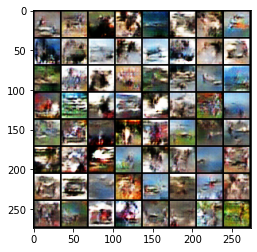

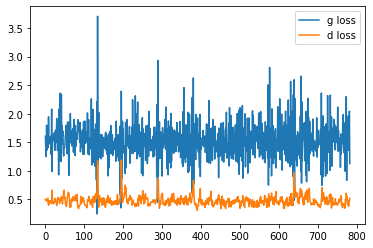

it: 982; g_loss: 1.3152544498443604; d_loss: 0.4617762565612793; avg_real_score: 0.5064464807510376; avg_fake_score: 0.17340734601020813: : 200it [00:26,  7.70it/s]

generated images


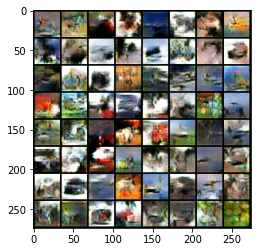

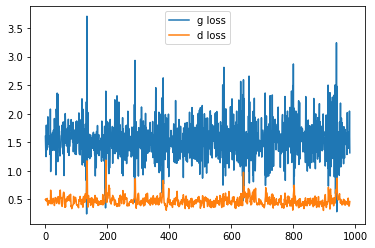

it: 1172; g_loss: 1.6727160215377808; d_loss: 0.44312605261802673; avg_real_score: 0.5427970886230469; avg_fake_score: 0.19387821853160858: : 391it [00:51,  7.66it/s]
it: 1173; g_loss: 1.30096435546875; d_loss: 0.3900899291038513; avg_real_score: 0.6608412861824036; avg_fake_score: 0.27681878209114075: : 0it [00:00, ?it/s]

generated images


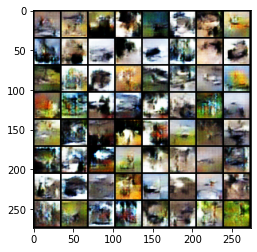

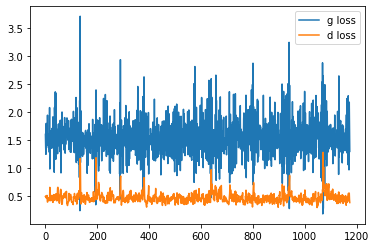

it: 1373; g_loss: 1.3742589950561523; d_loss: 0.42826515436172485; avg_real_score: 0.6228485107421875; avg_fake_score: 0.28321772813796997: : 200it [00:26,  7.83it/s]

generated images


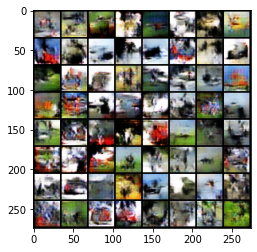

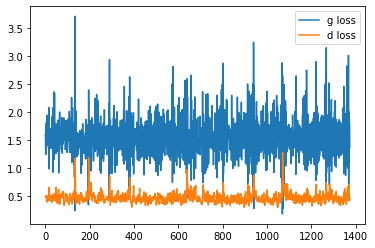

it: 1563; g_loss: 2.191128969192505; d_loss: 0.4956547021865845; avg_real_score: 0.7650259733200073; avg_fake_score: 0.4739546775817871: : 391it [00:51,  7.54it/s]
it: 1564; g_loss: 1.138676643371582; d_loss: 0.415885865688324; avg_real_score: 0.5664214491844177; avg_fake_score: 0.19527378678321838: : 0it [00:00, ?it/s]

generated images


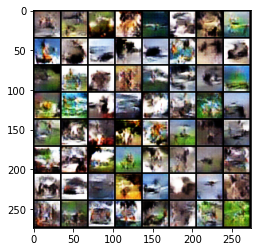

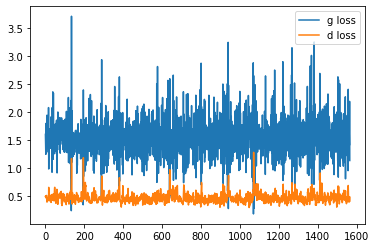

it: 1764; g_loss: 1.7670214176177979; d_loss: 0.49837726354599; avg_real_score: 0.6834551095962524; avg_fake_score: 0.4281405806541443: : 200it [00:27,  7.26it/s]  

generated images


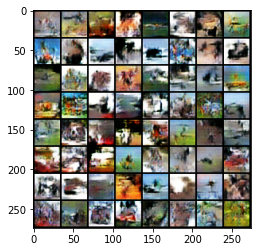

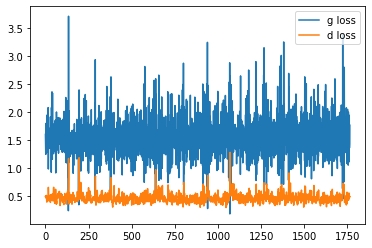

it: 1954; g_loss: 1.3958147764205933; d_loss: 0.4453815221786499; avg_real_score: 0.6053861379623413; avg_fake_score: 0.27655959129333496: : 391it [00:53,  7.30it/s]
it: 1955; g_loss: 2.132704734802246; d_loss: 0.3677048683166504; avg_real_score: 0.7909723520278931; avg_fake_score: 0.3657572269439697: : 0it [00:00, ?it/s]

generated images


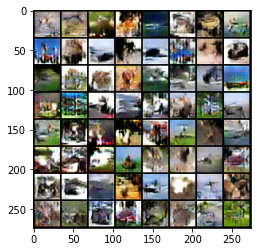

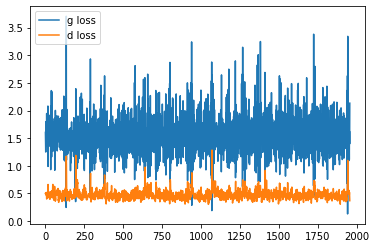

it: 2155; g_loss: 1.2600080966949463; d_loss: 0.4689098596572876; avg_real_score: 0.5336244702339172; avg_fake_score: 0.22375936806201935: : 200it [00:27,  7.37it/s]

generated images


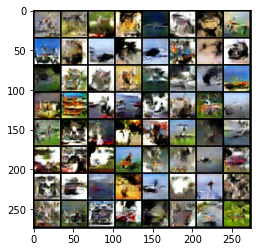

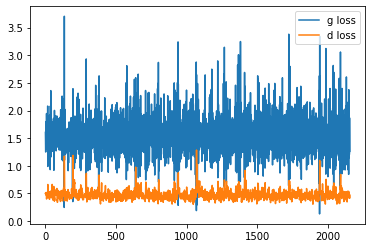

it: 2345; g_loss: 1.912596583366394; d_loss: 0.2566050589084625; avg_real_score: 0.780659019947052; avg_fake_score: 0.21789336204528809: : 391it [00:54,  7.24it/s]
it: 2346; g_loss: 1.603764533996582; d_loss: 0.36965125799179077; avg_real_score: 0.6732678413391113; avg_fake_score: 0.262617290019989: : 0it [00:00, ?it/s]

generated images


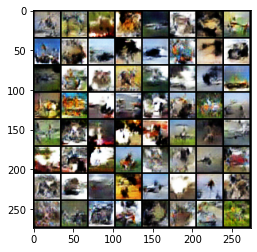

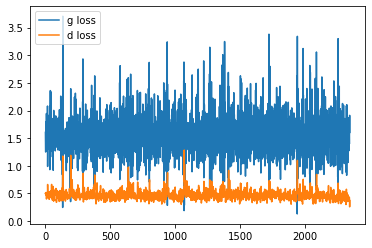

it: 2546; g_loss: 1.4557865858078003; d_loss: 0.4597969651222229; avg_real_score: 0.5581281185150146; avg_fake_score: 0.24475347995758057: : 200it [00:27,  7.37it/s]

generated images


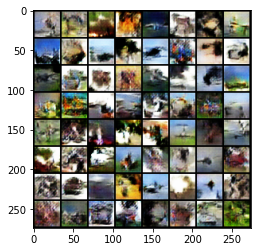

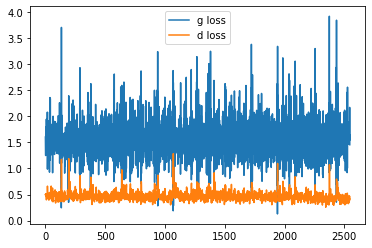

it: 2736; g_loss: 2.3081953525543213; d_loss: 0.3334730267524719; avg_real_score: 0.7801700234413147; avg_fake_score: 0.3201507031917572: : 391it [00:54,  7.21it/s]
it: 2737; g_loss: 1.2724132537841797; d_loss: 0.3083675503730774; avg_real_score: 0.69081711769104; avg_fake_score: 0.19357064366340637: : 0it [00:00, ?it/s]

generated images


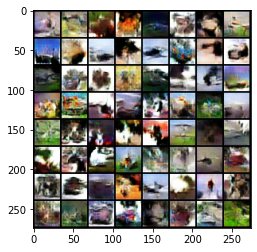

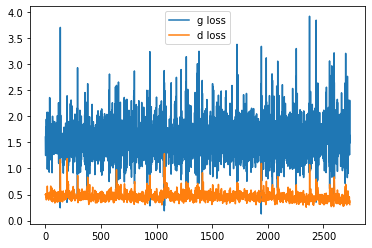

it: 2937; g_loss: 2.7454371452331543; d_loss: 0.42872440814971924; avg_real_score: 0.9027987122535706; avg_fake_score: 0.501007080078125: : 200it [00:27,  7.23it/s] 

generated images


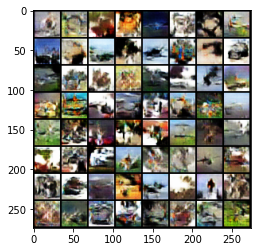

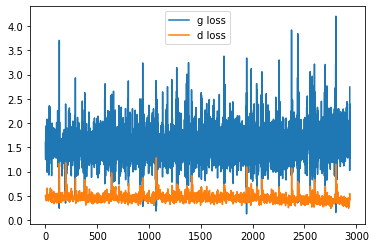

it: 3127; g_loss: 1.660711646080017; d_loss: 0.3420023024082184; avg_real_score: 0.5990671515464783; avg_fake_score: 0.10984878987073898: : 391it [00:54,  7.20it/s]
it: 3128; g_loss: 1.1674838066101074; d_loss: 0.3772417902946472; avg_real_score: 0.7175045609474182; avg_fake_score: 0.3156963884830475: : 0it [00:00, ?it/s]

generated images


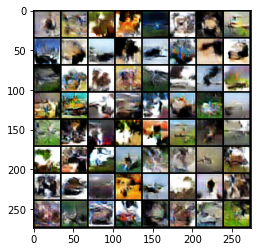

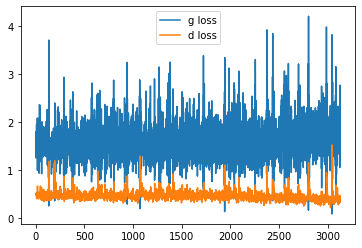

it: 3328; g_loss: 1.6315913200378418; d_loss: 0.34943825006484985; avg_real_score: 0.7831807136535645; avg_fake_score: 0.33826199173927307: : 200it [00:27,  7.26it/s]

generated images


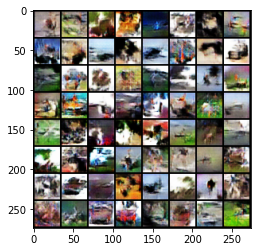

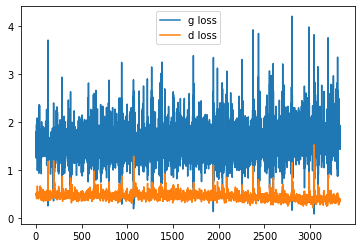

it: 3518; g_loss: 2.0431478023529053; d_loss: 0.29611578583717346; avg_real_score: 0.7021645903587341; avg_fake_score: 0.18851400911808014: : 391it [00:54,  7.17it/s]
it: 3519; g_loss: 1.9662312269210815; d_loss: 0.2540521025657654; avg_real_score: 0.7754606604576111; avg_fake_score: 0.2068254053592682: : 0it [00:00, ?it/s]

generated images


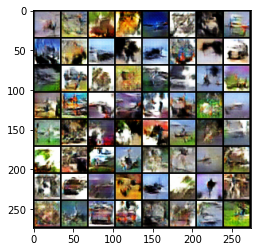

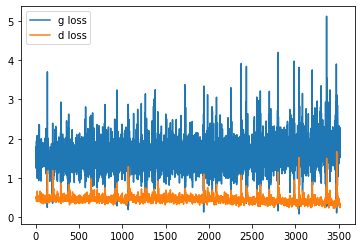

it: 3719; g_loss: 1.663813591003418; d_loss: 0.33180058002471924; avg_real_score: 0.6821005940437317; avg_fake_score: 0.20987842977046967: : 200it [00:27,  7.43it/s]

generated images


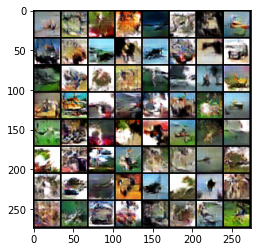

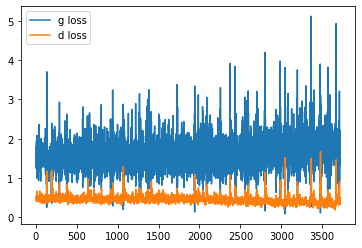

it: 3909; g_loss: 1.581816554069519; d_loss: 0.5637212991714478; avg_real_score: 0.6520454287528992; avg_fake_score: 0.45813703536987305: : 391it [00:54,  7.21it/s]
it: 3910; g_loss: 1.6163909435272217; d_loss: 0.41422152519226074; avg_real_score: 0.6698788404464722; avg_fake_score: 0.30526888370513916: : 0it [00:00, ?it/s]

generated images


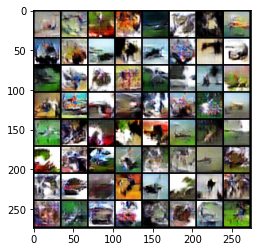

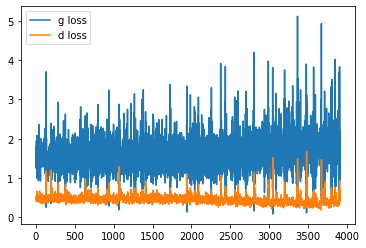

it: 4110; g_loss: 1.8517444133758545; d_loss: 0.30631908774375916; avg_real_score: 0.6998717784881592; avg_fake_score: 0.19530799984931946: : 200it [00:27,  7.32it/s]

generated images


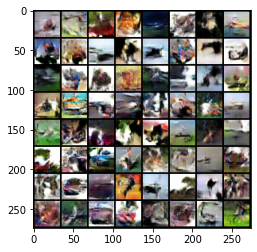

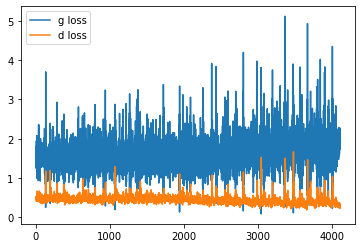

it: 4300; g_loss: 1.7269188165664673; d_loss: 0.2799746096134186; avg_real_score: 0.7109358906745911; avg_fake_score: 0.17612262070178986: : 391it [00:54,  7.20it/s]
it: 4301; g_loss: 2.5582947731018066; d_loss: 0.30007702112197876; avg_real_score: 0.8770356178283691; avg_fake_score: 0.3494609594345093: : 0it [00:00, ?it/s]

generated images


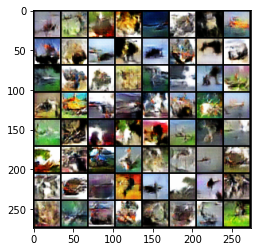

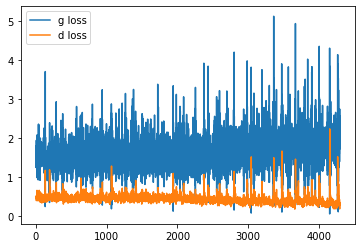

it: 4501; g_loss: 2.404129981994629; d_loss: 0.18549701571464539; avg_real_score: 0.805168628692627; avg_fake_score: 0.1323220431804657: : 200it [00:27,  7.38it/s]

generated images


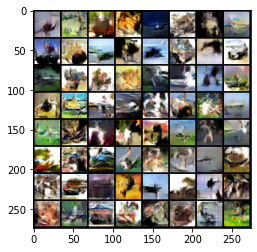

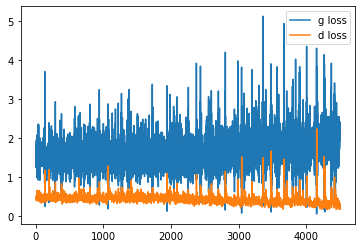

it: 4691; g_loss: 2.324709892272949; d_loss: 0.25086531043052673; avg_real_score: 0.8706413507461548; avg_fake_score: 0.29069074988365173: : 391it [00:54,  7.18it/s]
it: 4692; g_loss: 1.558753490447998; d_loss: 0.3711479902267456; avg_real_score: 0.6842801570892334; avg_fake_score: 0.26736873388290405: : 0it [00:00, ?it/s]

generated images


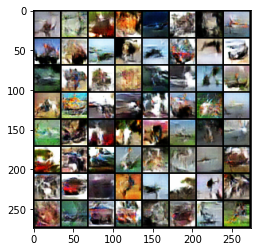

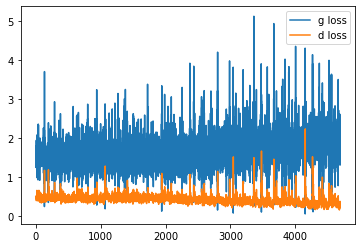

it: 4892; g_loss: 1.537252426147461; d_loss: 0.40233665704727173; avg_real_score: 0.7011057138442993; avg_fake_score: 0.3360048532485962: : 200it [00:28,  7.13it/s]

generated images


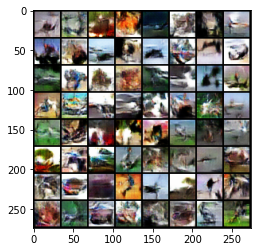

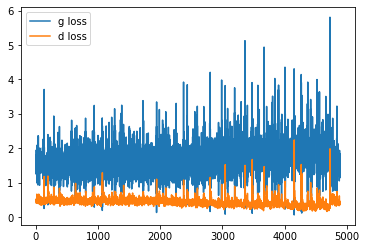

it: 5082; g_loss: 2.0990102291107178; d_loss: 0.3009748160839081; avg_real_score: 0.9087077379226685; avg_fake_score: 0.3752610385417938: : 391it [00:54,  7.17it/s]
it: 5083; g_loss: 2.4659981727600098; d_loss: 0.22144821286201477; avg_real_score: 0.8850642442703247; avg_fake_score: 0.25717824697494507: : 0it [00:00, ?it/s]

generated images


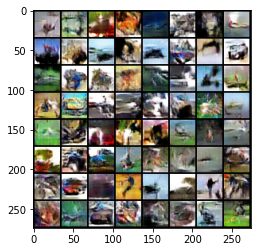

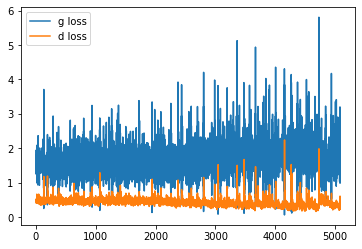

it: 5283; g_loss: 1.9034913778305054; d_loss: 0.4258078336715698; avg_real_score: 0.702562689781189; avg_fake_score: 0.35414254665374756: : 200it [00:28,  7.16it/s]  

generated images


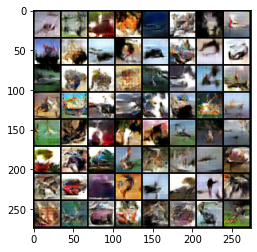

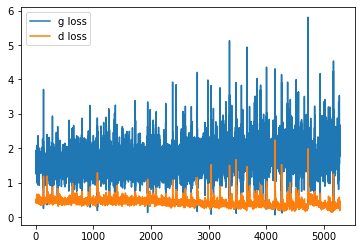

it: 5473; g_loss: 2.011889696121216; d_loss: 0.2699111998081207; avg_real_score: 0.7351464033126831; avg_fake_score: 0.18000248074531555: : 391it [00:54,  7.12it/s]
it: 5474; g_loss: 2.489095687866211; d_loss: 0.1901927888393402; avg_real_score: 0.8293672204017639; avg_fake_score: 0.1637936532497406: : 0it [00:00, ?it/s]

generated images


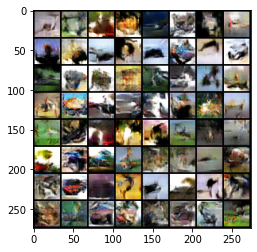

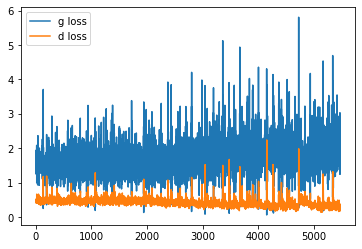

it: 5674; g_loss: 1.664708137512207; d_loss: 0.3539857268333435; avg_real_score: 0.6229382753372192; avg_fake_score: 0.15548378229141235: : 200it [00:28,  7.20it/s]

generated images


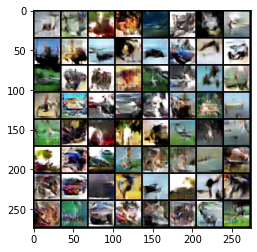

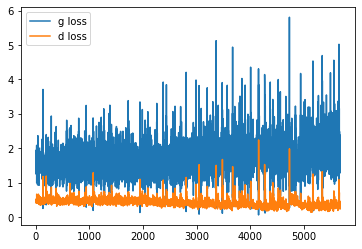

it: 5864; g_loss: 2.558772563934326; d_loss: 0.20411497354507446; avg_real_score: 0.8629801869392395; avg_fake_score: 0.21355699002742767: : 391it [00:54,  7.13it/s]
it: 5865; g_loss: 1.3602657318115234; d_loss: 0.27533960342407227; avg_real_score: 0.692726194858551; avg_fake_score: 0.14203248918056488: : 0it [00:00, ?it/s]

generated images


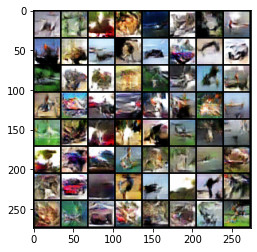

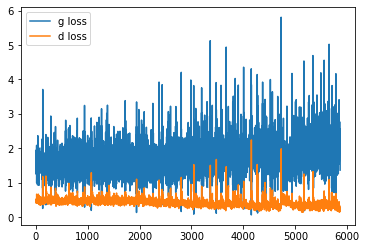

it: 6065; g_loss: 1.9495632648468018; d_loss: 0.1824532449245453; avg_real_score: 0.8260124325752258; avg_fake_score: 0.1420840471982956: : 200it [00:27,  7.40it/s]  

generated images


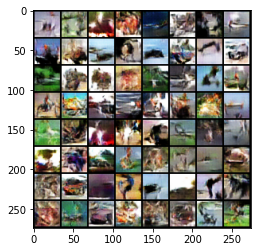

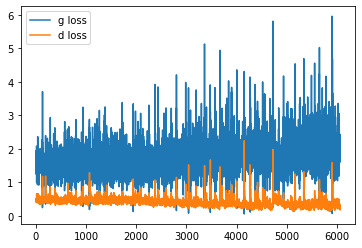

it: 6255; g_loss: 1.9206184148788452; d_loss: 0.33925867080688477; avg_real_score: 0.7160415053367615; avg_fake_score: 0.25742247700691223: : 391it [00:54,  7.15it/s]
it: 6256; g_loss: 1.6187338829040527; d_loss: 0.3646767735481262; avg_real_score: 0.6934859752655029; avg_fake_score: 0.2602793872356415: : 0it [00:00, ?it/s]

generated images


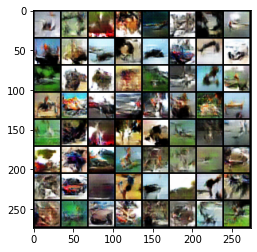

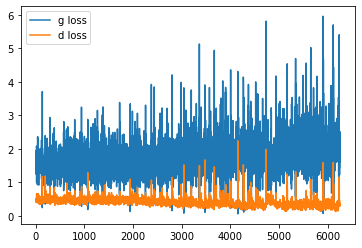

it: 6456; g_loss: 3.464344024658203; d_loss: 0.4298289120197296; avg_real_score: 0.9214732050895691; avg_fake_score: 0.5018786191940308: : 200it [00:28,  7.34it/s]  

generated images


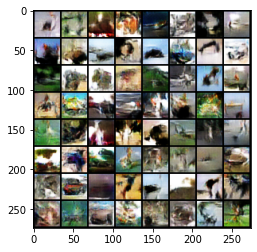

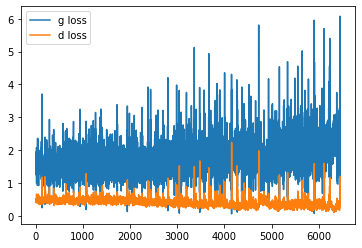

it: 6646; g_loss: 1.1773918867111206; d_loss: 0.4774901270866394; avg_real_score: 0.5868555903434753; avg_fake_score: 0.28482523560523987: : 391it [00:54,  7.14it/s]
it: 6647; g_loss: 2.898481845855713; d_loss: 0.3900524377822876; avg_real_score: 0.8775601387023926; avg_fake_score: 0.41925227642059326: : 0it [00:00, ?it/s]

generated images


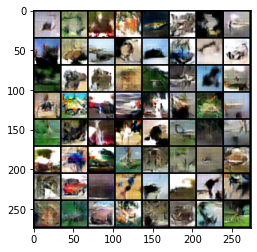

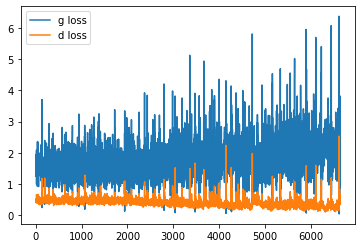

it: 6847; g_loss: 2.1278839111328125; d_loss: 0.21599946916103363; avg_real_score: 0.8040425181388855; avg_fake_score: 0.17219990491867065: : 200it [00:28,  7.37it/s]

generated images


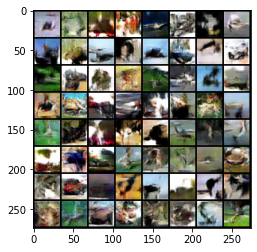

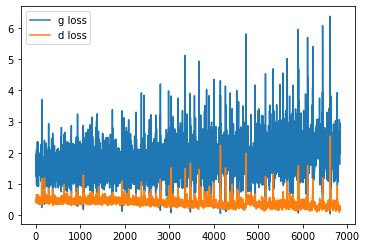

it: 7037; g_loss: 2.295267343521118; d_loss: 0.1722584217786789; avg_real_score: 0.8055545687675476; avg_fake_score: 0.10696158558130264: : 391it [00:54,  7.13it/s]
it: 7038; g_loss: 3.4801793098449707; d_loss: 0.2997824251651764; avg_real_score: 0.9128309488296509; avg_fake_score: 0.3697510361671448: : 0it [00:00, ?it/s]

generated images


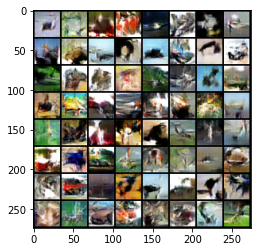

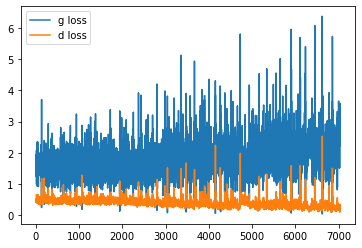

it: 7238; g_loss: 2.4574248790740967; d_loss: 0.22090372443199158; avg_real_score: 0.8544963002204895; avg_fake_score: 0.22577327489852905: : 200it [00:28,  7.17it/s]

generated images


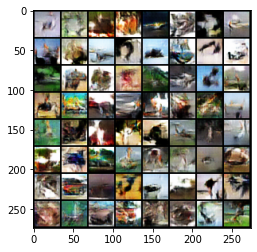

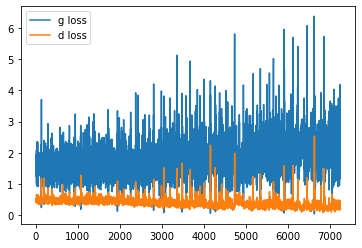

it: 7428; g_loss: 2.739527463912964; d_loss: 0.2896425724029541; avg_real_score: 0.7103249430656433; avg_fake_score: 0.1735811084508896: : 391it [00:54,  7.12it/s]
it: 7429; g_loss: 2.5326225757598877; d_loss: 0.15146562457084656; avg_real_score: 0.8752918243408203; avg_fake_score: 0.14514203369617462: : 0it [00:00, ?it/s]

generated images


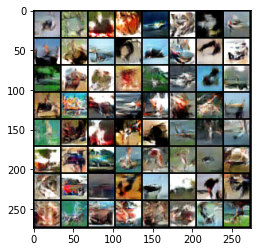

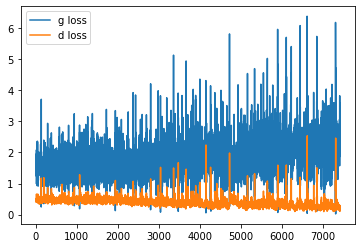

it: 7629; g_loss: 2.0533952713012695; d_loss: 0.31562340259552; avg_real_score: 0.7417225241661072; avg_fake_score: 0.24580644071102142: : 200it [00:28,  7.33it/s]   

generated images


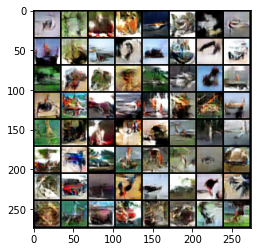

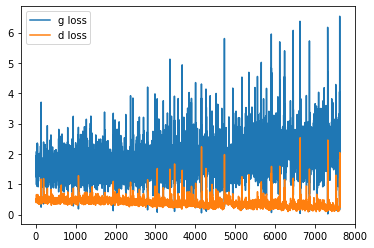

it: 7819; g_loss: 1.7362316846847534; d_loss: 0.33645832538604736; avg_real_score: 0.6218116879463196; avg_fake_score: 0.13709788024425507: : 391it [00:54,  7.17it/s]


In [ ]:
nb_epochs = 20

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z=sample_z(cur_batch_size,nz)
        one_label=get_labels_one(cur_batch_size)
        zero_label=get_labels_zero(cur_batch_size)
        # 2. Generate a fake image
        fake_image=netG(z)
        # 3. Classify real image with D
        yhat_real=netD(im)

        real_loss=criterion(yhat_real,one_label)
        # 4. Classify fake image with D
        yhat_fake=netD(fake_image.detach())
        fake_loss=criterion(yhat_fake,zero_label)


        
        
        ###
        ### Discriminator
        ###
        
        d_loss = (real_loss+fake_loss)/2.#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward() # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        
        g_loss = criterion(netD(fake_image),one_label) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

generated images


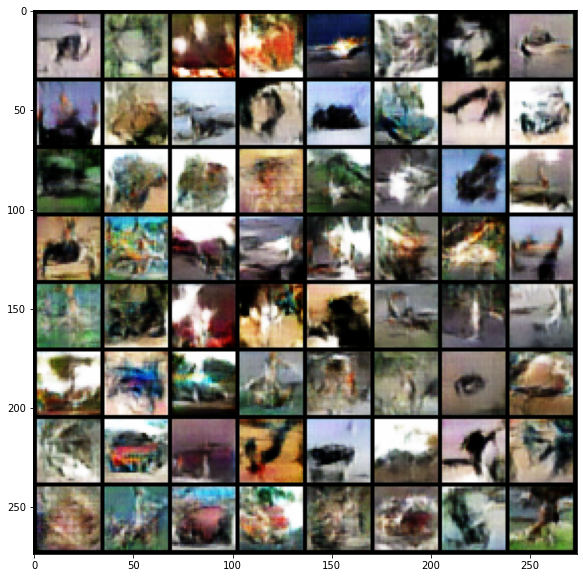

In [ ]:
fake_im = netG(z_test)
            
un_norm = renorm(fake_im) # for visualization
            
grid = torchvision.utils.make_grid(un_norm, nrow=8)
pil_grid = to_pil(grid)  
plt.figure(figsize=(10,10))           
print("generated images")
plt.imshow(pil_grid)
plt.show()

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [ ]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()
        
        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        self.rest_model = nn.Sequential(get_upscaling_block(ngf * 8 * 2, ngf * 4, 4, 1, 1),
                                   get_upscaling_block(ngf * 4, ngf * 2, 4, 2, 1),
                                   get_upscaling_block(ngf * 2, ngf , 4, 2, 1),
                                   get_upscaling_block(ngf , nchannels, 4, 2, 1,last_layer=True))   
        
        ###################
        
    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        x=torch.cat([self.upscaling_z(x),self.upscaling_c(y)],dim=1)
        return self.rest_model(x)

### 4.1.2 Discriminator

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=True)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=True)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        
        self.rest = nn.Sequential(get_downscaling_block(ndf*4,ndf*4,4,2,1),
                                  get_downscaling_block(ndf*4,ndf*8,4,2,1),
                                  get_downscaling_block(ndf*8,1,4,2,0,is_last=True))
        
        #                 #
        ###################
        
    def forward(self, x, y):
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        y = y.unsqueeze(2).unsqueeze(2).repeat(1,1,x.shape[2], x.shape[3])
        x=self.downscale_x(x)
        y=self.downscale_y(y)
        x=torch.cat([x,y],dim=1)
        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 4.1.3 Sanity Checks

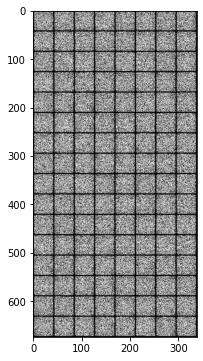

In [ ]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [ ]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)

assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

## 4.2 Training

In [ ]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)
        
netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



it: 0; g_loss: 1.4805365800857544; d_loss: 0.9426714181900024; avg_real_score: 0.35153135657310486; avg_fake_score: 0.4996439218521118: : 0it [00:00, ?it/s]

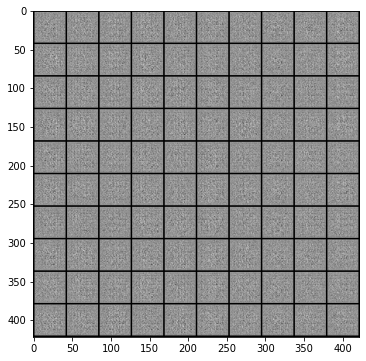

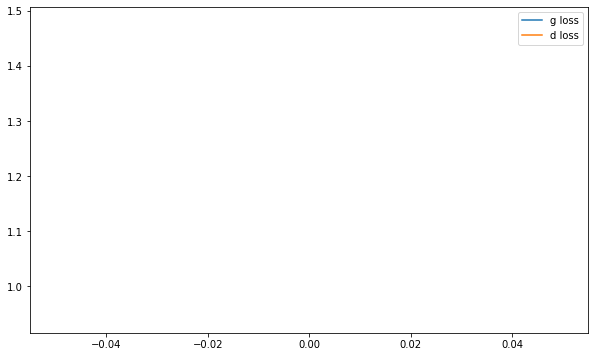

it: 200; g_loss: 6.208674430847168; d_loss: 0.0025907738599926233; avg_real_score: 0.997658371925354; avg_fake_score: 0.002830108627676964: : 200it [00:49,  4.13it/s] 

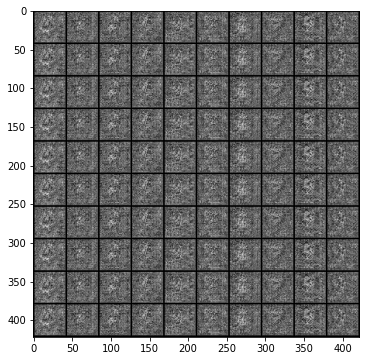

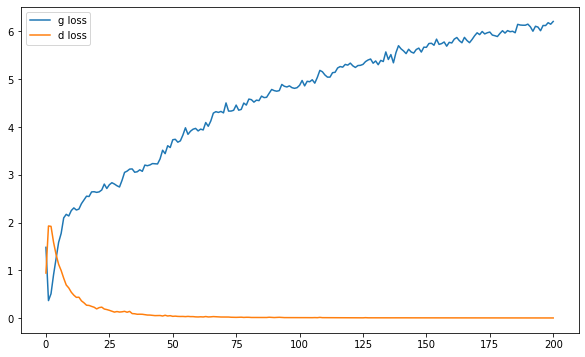

it: 219; g_loss: 6.259559631347656; d_loss: 0.0021354914642870426; avg_real_score: 0.9983059167861938; avg_fake_score: 0.002569639589637518: : 220it [00:55,  3.97it/s]


KeyboardInterrupt: ignored

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing


for epoch in range(nb_epochs):
    
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch 
        im = im.to(device)
        
        
        y = F.one_hot(labels).float().to(device)
        cur_batch_size = im.shape[0]  
        gen_labels = F.one_hot(torch.randint(0, nc, [cur_batch_size])).float().to(device)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        zero_label= get_labels_zero(cur_batch_size)
        one_label=get_labels_one(cur_batch_size)

        # 1. sample a z vector 
        z=sample_z(cur_batch_size,nz)
        # 2. Generate a fake image
        fake_image=netG(z,gen_labels)
        # 3. Classify real image with D
        yhat_real=netD(im,y)
        real_loss=criterion(yhat_real,one_label)
        # 4. Classify fake image with D
        yhat_fake=netD(fake_image.detach(),gen_labels)
        fake_loss=criterion(yhat_fake,zero_label)
        
        
        ###
        ### Discriminator
        ###
        
        d_loss = (real_loss+fake_loss)/2 # YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward() # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()
        
        
        ###
        ### Generator
        ###
        

        g_loss = criterion(netD(fake_image,gen_labels),one_label) # YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)  
            
            plt.imshow(pil_grid)
            plt.show()
            
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1
            

## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

In [ ]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)  

plt.imshow(pil_grid)
plt.show()
